# 🎯 Benchmark: `dataclasses` vs `pydantic v2` vs `msgspec`

This notebook benchmarks **instantiation**, **JSON encoding**, and **JSON decoding**
for three different approaches:

- Standard library **`dataclasses`**
- **Pydantic v2** (`BaseModel`)
- **msgspec** (`Struct`)

We run two types of benchmarks:

1. **Microbenchmark (single object, many repetitions)**  
   - Measures *pure function speed* on one representative user object.

2. **Batch benchmark (many different objects, processed once)**  
   - Measures *throughput* and *scaling* on a realistic batch of users.

Finally, we visualize the results with bar charts for:

- `encode`
- `decode`
- `encode + decode` (total)

## ⭐ PART 1 — Import Benchmark Functions:

In [1]:
from benchmark_dataclass import instantiate_dataclass, encode_dataclass, decode_dataclass
from benchmark_pydantic import instantiate_pydantic, encode_pydantic, decode_pydantic
from benchmark_msgspec import instantiate_msgspec, encode_msgspec, decode_msgspec
from data_generator import generate_users_batch

import statistics
from time import perf_counter
from typing import Callable, Any, Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

COLORS = {
    'header': '\033[95m',
    'blue': '\033[94m',
    'cyan': '\033[96m',
    'green': '\033[92m',
    'warning': '\033[93m',
    'fail': '\033[91m',
    'endc': '\033[0m',
    'bold': '\033[1m',
    'underline': '\033[4m'
}

def color_text(text: str, color: str) -> str:
    return f"{COLORS.get(color, COLORS['endc'])}{text}{COLORS['endc']}"



## ⭐ PART 2 — Microbenchmark Helper:

* We will measure the `SAME ITEM` repeated many times.

In [2]:
def micro_benchmark(
    fn: Callable[..., Any],
    *args: Any,
    iterations: int = 20_000,
    warmup: int = 2_000,
    **kwargs: Any,
) -> float:
    """
    Run fn(*args, **kwargs) many times and return average time in microseconds.
    Used for single-object benchmarks.
    """
    # Warm-up (JIT-like effects, caches, etc.)
    for _ in range(warmup):
        fn(*args, **kwargs)

    times: List[float] = []
    for _ in range(iterations):
        start = perf_counter()
        fn(*args, **kwargs)
        end = perf_counter()
        times.append(end - start)

    avg_us: float = statistics.mean(times) * 1e6
    return avg_us

✔ **Purpose**:
  * Measure pure function cost;
  * Very stable (many repetitions);
  * Used by msgspec vs pydantic authors as well.
  

## ⭐ PART 3 — Batch Benchmark Helper:

* We will measure `MANY DIFFERENT ITEMS` processed once.


In [3]:
def batch_benchmark(
    fn: Callable[[Any], Any],
    batch: List[Any],
    warmup: int = 1,
) -> Tuple[float, float]:
    """
    Run fn(item) for each item in batch once.
    Returns: (avg_time_per_item_µs, total_time_seconds).
    """
    # Warm-up on first element
    for _ in range(warmup):
        fn(batch[0])

    start: float = perf_counter()
    for item in batch:
        fn(item)
    end: float = perf_counter()

    total: float = end - start
    avg_us: float = (total / len(batch)) * 1e6
    return avg_us, total

✔ **Purpose**:
  * Measures throughput on real workload;
  * Per-item time and total time.

## ⭐ PART 4 — RUN MICROBENCHMARK (single user)

In [4]:
# Settings:
batch_size = 1
iterations_micro = 1_000_000

# Generate a single user dict
generated_data = generate_users_batch(batch_size=batch_size)
generated_data = generate_users_batch(batch_size=1)

# Single user for microbenchmark:
single_user = generated_data[0]

# Instantiate objects once (we reuse them for encode/decode microbenchmarks):
dc_obj = instantiate_dataclass(single_user)
py_obj = instantiate_pydantic(single_user)
ms_obj = instantiate_msgspec(single_user)

# Encode once:
dc_encoded = encode_dataclass(dc_obj)
py_encoded = encode_pydantic(py_obj)
ms_encoded = encode_msgspec(ms_obj)

# Decode once (sanity check only; not timed here):
dc_decoded = decode_dataclass(dc_encoded)
py_decoded = decode_pydantic(py_encoded)
ms_decoded = decode_msgspec(ms_encoded)


In [6]:
micro_results: Dict[str, Dict[str, float]] = {
    "instantiate": {},
    "encode": {},
    "decode": {},
}

start_time = perf_counter()
# Instantiate
micro_results["instantiate"]["dataclass"] = micro_benchmark(
    instantiate_dataclass, single_user, iterations=iterations_micro
)
micro_results["instantiate"]["pydantic"] = micro_benchmark(
    instantiate_pydantic, single_user, iterations=iterations_micro
)
micro_results["instantiate"]["msgspec"] = micro_benchmark(
    instantiate_msgspec, single_user, iterations=iterations_micro
)

# Encode (no-arg lambdas calling encode on pre-created instance)
micro_results["encode"]["dataclass"] = micro_benchmark(
    encode_dataclass, dc_obj, iterations=iterations_micro
)
micro_results["encode"]["pydantic"] = micro_benchmark(
    encode_pydantic, py_obj, iterations=iterations_micro
)
micro_results["encode"]["msgspec"] = micro_benchmark(
    encode_msgspec, ms_obj, iterations=iterations_micro
)

# Decode (no-arg lambdas calling decode on pre-created bytes)
micro_results["decode"]["dataclass"] = micro_benchmark(
    decode_dataclass, dc_encoded, iterations=iterations_micro
)
micro_results["decode"]["pydantic"] = micro_benchmark(
    decode_pydantic, py_encoded, iterations=iterations_micro
)
micro_results["decode"]["msgspec"] = micro_benchmark(
    decode_msgspec, ms_encoded, iterations=iterations_micro
)

end_time = perf_counter()

print(color_text("=============== Microbenchmark: single-object repeated ===============", "bold"))
for lib in ["dataclass", "pydantic", "msgspec"]:
    inst = micro_results["instantiate"][lib]
    enc = micro_results["encode"][lib]
    dec = micro_results["decode"][lib]
    print(
        f"{lib.capitalize():9s}: "
        f"{color_text('instantiate', 'warning')} = {color_text(f'{inst:.2f}', 'fail')} µs | "
        f"{color_text('encode', 'warning')} = {color_text(f'{enc:.2f}', 'fail')} µs | "
        f"{color_text('decode', 'warning')} = {color_text(f'{dec:.2f}', 'fail')} µs"
    )
print(color_text("=======================================================================", "bold"))

total_micro_time = end_time - start_time
print(f"Total time for microbenchmark: {total_micro_time:.2f} seconds")

=============== Microbenchmark: single-object repeated ===============
Dataclass: instantiate = 0.27 µs | encode = 2.84 µs | decode = 1.51 µs
Pydantic : instantiate = 0.81 µs | encode = 0.76 µs | decode = 0.93 µs
Msgspec  : instantiate = 0.19 µs | encode = 0.15 µs | decode = 0.24 µs
Total time for microbenchmark: 9.70 seconds


### 📊 Microbenchmark Plot:

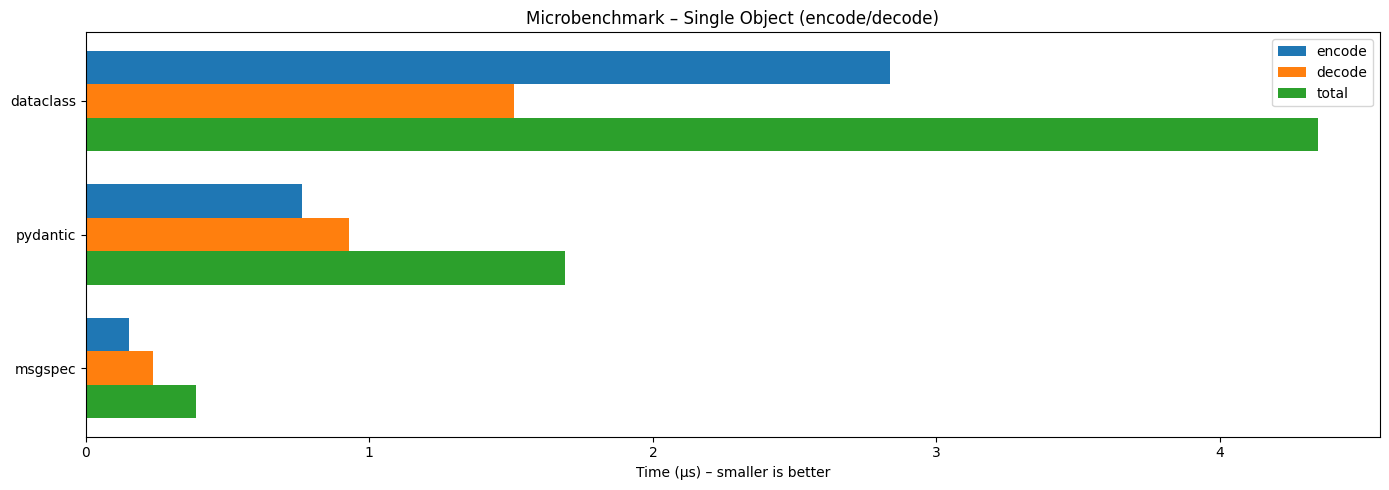

In [8]:
labels = ["dataclass", "pydantic", "msgspec"]

encode_vals = [micro_results["encode"][lib] for lib in labels]
decode_vals = [micro_results["decode"][lib] for lib in labels]
total_vals  = [encode_vals[i] + decode_vals[i] for i in range(len(labels))]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(14, 5))

plt.barh(x - width, encode_vals, height=width, label="encode")
plt.barh(x,         decode_vals, height=width, label="decode")
plt.barh(x + width, total_vals,  height=width, label="total")

plt.title("Microbenchmark – Single Object (encode/decode)")
plt.xlabel("Time (µs) – smaller is better"); plt.yticks(x, labels)

plt.gca().invert_yaxis(); plt.tight_layout()
plt.legend(); plt.show()


## ⭐ PART 5 — RUN BATCH BENCHMARK (1000 different users)


In [20]:
batch_size = 100_000
users_batch = generate_users_batch(batch_size=batch_size)

batch_results: Dict[str, Dict[str, Dict[str, float]]] = {
    "instantiate": {},
    "encode": {},
    "decode": {},
}


### 🚀 Batch Benchmark: Many Different Objects Once

In [21]:
print(f"Running batch benchmark with batch_size = {color_text(batch_size, 'header')} users...")

dc_inst_avg, dc_inst_tot = batch_benchmark(instantiate_dataclass, users_batch)
py_inst_avg, py_inst_tot = batch_benchmark(instantiate_pydantic, users_batch)
ms_inst_avg, ms_inst_tot = batch_benchmark(instantiate_msgspec, users_batch)

batch_results["instantiate"]["dataclass"] = {"avg_us": dc_inst_avg, "total_s": dc_inst_tot}
batch_results["instantiate"]["pydantic"] = {"avg_us": py_inst_avg, "total_s": py_inst_tot}
batch_results["instantiate"]["msgspec"]  = {"avg_us": ms_inst_avg, "total_s": ms_inst_tot}

# Instantiate once to get lists of objects
dc_objs = [instantiate_dataclass(u) for u in users_batch]
py_objs = [instantiate_pydantic(u) for u in users_batch]
ms_objs = [instantiate_msgspec(u) for u in users_batch]

# --- Encoding ---

dc_enc_avg, dc_enc_tot = batch_benchmark(encode_dataclass, dc_objs)
py_enc_avg, py_enc_tot = batch_benchmark(encode_pydantic, py_objs)
ms_enc_avg, ms_enc_tot = batch_benchmark(encode_msgspec, ms_objs)

batch_results["encode"]["dataclass"] = {"avg_us": dc_enc_avg, "total_s": dc_enc_tot}
batch_results["encode"]["pydantic"] = {"avg_us": py_enc_avg, "total_s": py_enc_tot}
batch_results["encode"]["msgspec"]  = {"avg_us": ms_enc_avg, "total_s": ms_enc_tot}

# Pre-encode once for decode benchmark
dc_encoded_batch = [encode_dataclass(o) for o in dc_objs]
py_encoded_batch = [encode_pydantic(o) for o in py_objs]
ms_encoded_batch = [encode_msgspec(o) for o in ms_objs]

# --- Decoding ---

dc_dec_avg, dc_dec_tot = batch_benchmark(decode_dataclass, dc_encoded_batch)
py_dec_avg, py_dec_tot = batch_benchmark(decode_pydantic, py_encoded_batch)
ms_dec_avg, ms_dec_tot = batch_benchmark(decode_msgspec, ms_encoded_batch)

batch_results["decode"]["dataclass"] = {"avg_us": dc_dec_avg, "total_s": dc_dec_tot}
batch_results["decode"]["pydantic"] = {"avg_us": py_dec_avg, "total_s": py_dec_tot}
batch_results["decode"]["msgspec"]  = {"avg_us": ms_dec_avg, "total_s": ms_dec_tot}

print(color_text("\n=============================== Batch benchmark: many different objects ==============================", "bold"))
for lib in ["dataclass", "pydantic", "msgspec"]:
    inst = batch_results["instantiate"][lib]
    enc  = batch_results["encode"][lib]
    dec  = batch_results["decode"][lib]
    print(
        f"{lib.capitalize():9s} | "
        f"inst: {color_text(f'{inst['avg_us']:.2f} µs', 'fail')} (total {inst['total_s']:.3f}s) | "
        f"enc:  {color_text(f'{enc['avg_us']:.2f} µs', 'fail')} (total {enc['total_s']:.3f}s) | "
        f"dec:  {color_text(f'{dec['avg_us']:.2f} µs', 'fail')} (total {dec['total_s']:.3f}s)"
    )
print(color_text("======================================================================================================", "bold"))

Running batch benchmark with batch_size = 100000 users...

=============================== Batch benchmark: many different objects ==============================
Dataclass | inst: 0.38 µs (total 0.038s) | enc:  2.72 µs (total 0.272s) | dec:  1.47 µs (total 0.147s)
Pydantic  | inst: 0.77 µs (total 0.077s) | enc:  0.78 µs (total 0.078s) | dec:  1.29 µs (total 0.129s)
Msgspec   | inst: 0.15 µs (total 0.015s) | enc:  0.12 µs (total 0.012s) | dec:  0.21 µs (total 0.021s)


### 🚀 Batch Benchmark: Many Different Objects Once

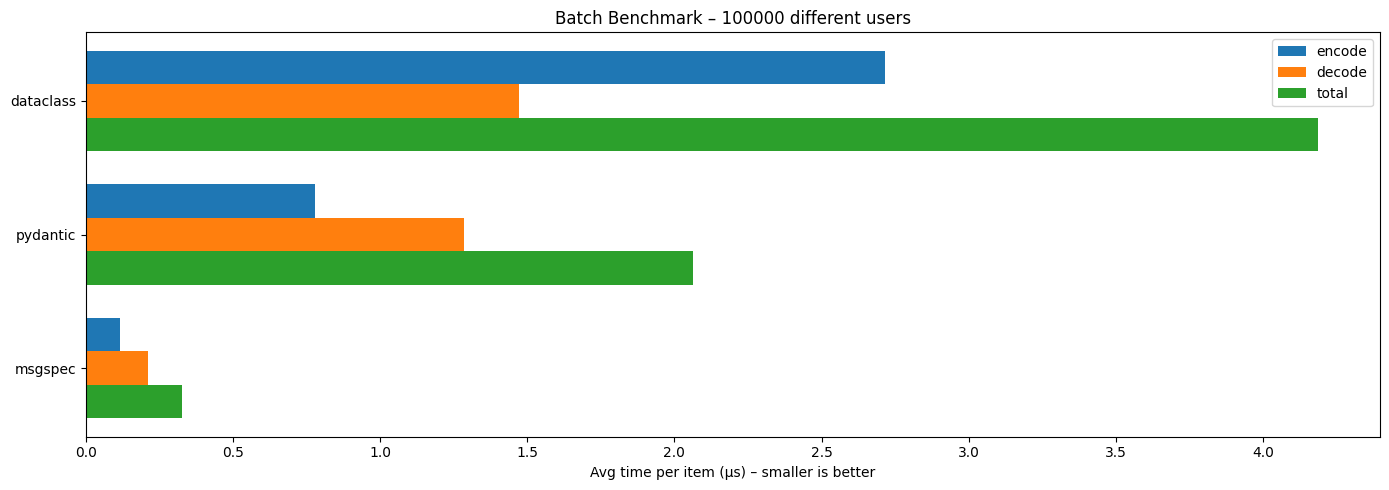

In [23]:
labels = ["dataclass", "pydantic", "msgspec"]

encode_vals_batch = [batch_results["encode"][lib]["avg_us"] for lib in labels]
decode_vals_batch = [batch_results["decode"][lib]["avg_us"] for lib in labels]
total_vals_batch  = [encode_vals_batch[i] + decode_vals_batch[i] for i in range(len(labels))]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(14, 5))
plt.barh(x - width, encode_vals_batch, height=width, label="encode")
plt.barh(x,         decode_vals_batch, height=width, label="decode")
plt.barh(x + width, total_vals_batch,  height=width, label="total")

plt.title(f"Batch Benchmark – {batch_size} different users")
plt.xlabel("Avg time per item (µs) – smaller is better"); plt.yticks(x, labels)
plt.gca().invert_yaxis(); plt.tight_layout()
plt.legend(); plt.show()
